## Midterm Lab Exam 

```
- Generative Artificial Intelligence (Fall semester 2023)
- Professor: Muhammad Fahim
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>

## Tasks
```
1. Variational AutoEncoder 
2. Conditional GAN (bonus)
```
All implementation in python and using PyTorch framework for neural networks
<hr>

## 0. Dataset

For both tasks CIFAR-10 dataset will be used

In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'available device : {device}')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

available device : cuda
Files already downloaded and verified


## 2. Task 1 (variational autoencoder)

* Implement and train a variational autoencoder for cifar 10 data using the achitecture below for generator and discriminator as baseline (you can only improve the achitecture by extending the achitecture on top of baseline)
* Implement a function that will generate images using the implemented vae 


### 2.1  VAE definition (20 points)

**Encoder Achitecture (baseline)**
- 3 convolutional layers whereby each layer is followed by batch normalization and relu activation function
  - Layer 1 : applies 32 filters
  - Layer 2 : applies 64 filters
  - Layer 3 : applies 128 filters

**Latent space**
- without activation

**Decoder Achitecture (baseline)**
- 3 deconvolutional layers whereby each layer is followed by batch normalization and relu activation function
- Mirror of the encoder network

**NB**: For both convolution and deconvolution `kernel_size=4, stride=2, padding=1`

In [2]:
def conv_block(input_channels, 
                output_channels, 
                kernel_size=4, 
                stride=2,
                padding: int = 1, 
                final_layer=False):
    
    layers = [
        nn.Conv2d(in_channels=input_channels,
                    out_channels=output_channels,
                    kernel_size=kernel_size,
                    stride=stride, 
                    padding=padding
                    )
    ]
    
    if not final_layer:
        layers.extend([nn.BatchNorm2d(output_channels), nn.ReLU(inplace=True)])
    return nn.Sequential(*layers)

def deconv_block(input_channels, 
                   output_channels,                 
                   kernel_size=4, 
                    stride=2,
                    padding: int = 1, 
                    final_layer: bool = False):
    
    layers = [
        nn.ConvTranspose2d(in_channels=input_channels, 
                            out_channels=output_channels,
                            kernel_size=kernel_size,
                            stride=stride,
                            padding=padding), 
    ]
    
    if final_layer:
        layers.append(nn.Tanh())    
    else: 
        layers.extend([nn.BatchNorm2d(output_channels), nn.ReLU()])
        
    return nn.Sequential(*layers)



In [3]:
class VAE(nn.Module):
    def __init__(self, channel_num=3, kernel_num=128, z_size=128, image_size=32):
        super(VAE, self).__init__()
        # the encoder is 3 layers
        self.z_dim = z_size

        self.encoder = nn.Sequential(conv_block(input_channels=channel_num, output_channels=32), 
                        conv_block(input_channels=32, output_channels=64), 
                        conv_block(input_channels=64, output_channels=128))
        
        # the latent dimensions 
        self.mu_layer = nn.LazyLinear(out_features=z_size)
        self.sigma_layer = nn.LazyLinear(out_features=z_size)

        self.latent_map = nn.Linear(in_features=self.z_dim, out_features=2048)

        self.decoder = nn.Sequential(deconv_block(input_channels=z_size, output_channels=64), 
                                     deconv_block(input_channels=64, output_channels=32), 
                                     deconv_block(input_channels=32, output_channels=3))
    
    def reparametrize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x: torch.Tensor):
        assert x.shape[-2:] == (32, 32)

        # first run through the encoder
        x_encoder = self.encoder(x)
        x_flat = nn.Flatten()(x_encoder)
        # save the dimension of the feature map
        _, fmw, fmh = x_encoder.shape[1:] 

        mean, log_var = self.mu_layer(x_flat), self.sigma_layer(x_flat)
        z = self.reparametrize(mean, log_var)
        # convert 'z' back the size of the flattened feature map
        z1 = self.latent_map(z)
        # unsqueeze 'z' to match the dimensions of unflattened encoder output
        z_image = z1.view(len(z), self.z_dim, fmw, fmh)
        
        return self.decoder(z_image), mean, log_var

    def generate(self, noise: torch.Tensor):
        with torch.no_grad():
            mean, log_var = self.mu_layer(noise), self.sigma_layer(noise)
            z = self.reparametrize(mean, log_var)
            # convert 'z' back the size of the flattened feature map
            z1 = self.latent_map(z)
            # unsqueeze 'z' to match the dimensions of unflattened encoder output
            z_image = z1.view(len(z1), self.z_dim, 4, 4)
            return self.decoder(z_image)


In [4]:
vae_model= VAE()
x = torch.rand(1, 3, 32, 32)
o, mu, var = vae_model.forward(x)
print(o.shape)
# we can see the architecture match the baseline described in the task
# print(vae_model)
print(mu.shape)
print(var.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 128])
torch.Size([1, 128])


/home/ayhem18/DEV/My_Kaggle_Repo/kaggle_env/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### 2.2 Training parameters definition (10 points)

- Define optimizer : Adam optimizer (default `weight_decay=1e-5, learning_rate=3e-04`)
- Define the criterion : kl-divergence loss and reconstruction loss

In [5]:
from torch.optim import Adam
from torch.nn import MSELoss
learning_rate = 3e-04 
mse = torch.nn.MSELoss()
vae_optimizer = Adam(vae_model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def reconstruction_loss(x_reconstructed, x):
    # define the criterion
    criterion =  MSELoss()
    return criterion(x_reconstructed, x)

def kl_divergence_loss(mu, logvar):
    total_loss = -0.5*torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=1)
    KL_loss = torch.mean(total_loss, dim=0) 
    return KL_loss

### 2.3 VAE Training and Evaluation (15 points)

- Define the training procedure and train the vae model 
- Add model evaluation every after (n batches) or (n epochs)

In [6]:
# let's define the hyperparameters needed
EPOCHS = 50
# the kl divergence is expected to be larger than MSE loss, 
# thus to balance the training we will update the values of the coefficient associated with KL divergence loss
KL_ALPHA_MIN = 10 ** -4
KL_ALPHA_MAX = 10 ** -2

In [7]:
import numpy as np
np.random.seed(69)
torch.manual_seed(69)
vae_model.to(device)

for epoch, alpha in zip(range(1, EPOCHS + 1), np.logspace(start=-7, stop=-5., num=EPOCHS)):
    print(alpha)
    KL_epoch_loss = 0
    R_epoch_loss = 0
    num_steps = 0

    for (x, _) in trainloader:
        x = x.to(device)
        x_pred, mu, log_sigma = vae_model(x)

        # calculate the losses
        r_loss = reconstruction_loss(x_pred, x)
        kl_loss = kl_divergence_loss(mu=mu, logvar=log_sigma)

        total_loss = r_loss + alpha * kl_loss

        vae_optimizer.zero_grad()
        total_loss.backward()
        vae_optimizer.step()

        num_steps += 1

        KL_epoch_loss += kl_loss.item()
        R_epoch_loss += r_loss.item()

    
    print("Epoch {}/{}\t KL Loss:\t{:.6f}\t\tR Loss:\t{:.6f}\t α={:.2E}"
        .format(epoch, EPOCHS, KL_epoch_loss / num_steps, R_epoch_loss / num_steps, alpha))



1e-07


Epoch 1/50	 KL Loss:	15975.650198		R Loss:	0.233485	 α=1.00E-07
1.0985411419875573e-07
Epoch 2/50	 KL Loss:	365.468310		R Loss:	0.178305	 α=1.10E-07
1.2067926406393288e-07
Epoch 3/50	 KL Loss:	418.190581		R Loss:	0.170548	 α=1.21E-07
1.3257113655901082e-07
Epoch 4/50	 KL Loss:	475.971910		R Loss:	0.164550	 α=1.33E-07
1.4563484775012443e-07
Epoch 5/50	 KL Loss:	526.024247		R Loss:	0.159849	 α=1.46E-07
1.5998587196060574e-07
Epoch 6/50	 KL Loss:	549.852472		R Loss:	0.157594	 α=1.60E-07
1.757510624854793e-07
Epoch 7/50	 KL Loss:	567.199572		R Loss:	0.156345	 α=1.76E-07
1.9306977288832497e-07
Epoch 8/50	 KL Loss:	576.864362		R Loss:	0.154965	 α=1.93E-07
2.1209508879201927e-07
Epoch 9/50	 KL Loss:	580.846358		R Loss:	0.154151	 α=2.12E-07
2.329951810515372e-07
Epoch 10/50	 KL Loss:	582.636687		R Loss:	0.153430	 α=2.33E-07
2.559547922699533e-07
Epoch 11/50	 KL Loss:	574.237084		R Loss:	0.152450	 α=2.56E-07
2.811768697974231e-07
Epoch 12/50	 KL Loss:	570.941412		R Loss:	0.152121	 α=2.81E-07
3.

### 2.4 Images generation (5 points)

- Implement a function that will take the number of images to be generated, generate images using the previously implemented vae and save them to folder

In [8]:
import cv2
from typing import Union
def display_image(image: Union[np.ndarray, torch.Tensor]):
    if isinstance(image, torch.Tensor):
        image = image.detach().permute(1, 2, 0).cpu().numpy()

    cv2.imshow('image', image)
    cv2.waitKey(0)
    cv2.destroyWindow(winname='image')
    return image
    
import matplotlib.pyplot as plt

def plot_images(images,
                captions= None,
                rows=2,
                columns=5,
                title="", **kwargs):
    """
    Plots images with captions

    :param images: list of images to plot
    :param captions: captions of images:
    :param rows: number of rows in figure
    :param columns: number of columns:
    :param title: super title of figure
    """
    fig = plt.figure(figsize=(6, 3))
    for i, img in enumerate(images):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img, **kwargs)

        if captions is not None:
            if i < len(captions):
                plt.title(captions[i])
        
        plt.axis("off")
    fig.suptitle(title)
    plt.show()

In [9]:
import os
torch.manual_seed(69)

def generate_images(num_images=5, model=vae_model, dir_path: str = None):

    if dir_path is None:
        dir_path = os.getcwd()
    
    images =  model.generate(torch.rand(num_images, 2048).to(device))
    for index, i in enumerate(images):
        i_numpy = display_image(i)
        cv2.imwrite(os.path.join(dir_path, f'image_{index}.jpg'), i_numpy)

# generate_images(num_images=5, model=vae_model)


In [10]:
device

'cuda'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


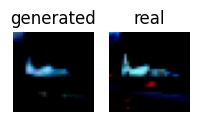

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


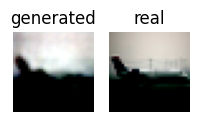

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


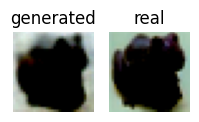

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


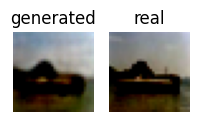

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


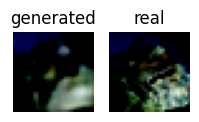

In [15]:
vae_model.to(device)
for x, _ in trainloader:
    x = x.to(device)
    with torch.no_grad():
        x_generated, mu, sigma = vae_model(x)
        # plot_images(x_generated[:5])
        for g, r in zip(x_generated[:5].cpu(), x[:5].cpu()):
            x_r_image = r.detach().permute(1, 2, 0).cpu().numpy()
            x_g_image = g.detach().permute(1, 2, 0).cpu().numpy()
            plot_images([x_g_image, x_r_image], captions=['generated', 'real'])
    
    break

## Bonus task (50 points)

- Grading for the bonus task is binary (its eighter you get it all correct or zero) -- One mistake equals zero 
- The bonus points scope is the midterm lab exam only (bonus points cannot be tranfered to other parts of the course)
- Implement a conditional GAN for CIFAR 10 data
- Train and evaluate cGAN 
- Log the training and validation perfomace metrics to `TensorBoard`
- Implement a function that will take a condition, generate images using the previously implemented conditional GAN and visualize the result

In [ ]:
## Your code here